In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pylab as plt
import os
import ipywidgets as widgets

import pyclesperanto_prototype as cle
from scipy import ndimage
from skimage import io, measure
from skimage.morphology import binary_closing, binary_opening, disk
from aicsimageio import AICSImage, imread
import apoc
from apoc import ObjectSegmenter
import napari
import tifffile

In [3]:
from image_analysis.read_files import get_paths, change_paths
from image_analysis.preprocess import plot
from image_analysis.preprocess import mask
from image_analysis.fit import roi

In [4]:
#----- information from metadata
channels = {
            "fgf":    0, 
            "shh":    1, 
            "bright":   2, 
            "dapi": 3, 
            "dusp":   4, 
            "auto":    5
           }

#-----
downsample = 2                  # downsampling level while image loading (the same along all axis)
R_average = 20                 # um, the radius of cyllinder for making 1d Shh-Fgf ROI
pixel_size_aim_user_def = 2e-6    # pixel size used while making 3d image isotropic

sigma = 5 # for gauss filter before thresholding

#Voxel size: 0.6764x0.6764x3.9991 micron^3

pixel_size_x, pixel_size_y, pixel_size_z = 2*0.9019, 2*0.9019, 2*3.9991

# Image folder

In [5]:
image_folder_tif = r'example_raw_images/'

In [6]:
sample = '2_5cm_7dpa_noif'

In [7]:
img_paths = get_paths(image_folder_tif, suffix='tif')
img_paths = change_paths(img_paths, include='niif')
img_paths

['example_raw_images/c6_hcr21_20240726_7d_niif_t4a#18.tif',
 'example_raw_images/c3_hcr21_20240726_7d_niif_t4a#18.tif',
 'example_raw_images/c2_hcr21_20240726_7d_niif_t4a#18.tif',
 'example_raw_images/c4_hcr21_20240726_7d_niif_t4a#18.tif',
 'example_raw_images/c5_hcr21_20240726_7d_niif_t4a#18.tif',
 'example_raw_images/c1_hcr21_20240726_7d_niif_t4a#18.tif']

In [8]:
img_paths = sorted(
    img_paths,
    key = lambda c: c.split('/c')[1].split('_')[0]
)

In [9]:
img_paths

['example_raw_images/c1_hcr21_20240726_7d_niif_t4a#18.tif',
 'example_raw_images/c2_hcr21_20240726_7d_niif_t4a#18.tif',
 'example_raw_images/c3_hcr21_20240726_7d_niif_t4a#18.tif',
 'example_raw_images/c4_hcr21_20240726_7d_niif_t4a#18.tif',
 'example_raw_images/c5_hcr21_20240726_7d_niif_t4a#18.tif',
 'example_raw_images/c6_hcr21_20240726_7d_niif_t4a#18.tif']

# Load images

In [10]:
img = []
for path in img_paths:
    print(path)
    i = tifffile.imread(path)
    #print(i.shape)
    img.append(i[::downsample, ::downsample, ::downsample])
img = np.array(img).astype( np.uint16 )

example_raw_images/c1_hcr21_20240726_7d_niif_t4a#18.tif
example_raw_images/c2_hcr21_20240726_7d_niif_t4a#18.tif
example_raw_images/c3_hcr21_20240726_7d_niif_t4a#18.tif
example_raw_images/c4_hcr21_20240726_7d_niif_t4a#18.tif
example_raw_images/c5_hcr21_20240726_7d_niif_t4a#18.tif
example_raw_images/c6_hcr21_20240726_7d_niif_t4a#18.tif


In [11]:
img.shape

(6, 15, 256, 256)

In [12]:
channels = list(channels.keys())

In [13]:
channels

['fgf', 'shh', 'bright', 'dapi', 'dusp', 'auto']

In [14]:
img = dict(zip(channels, img))

In [15]:
del img['bright']

# Isotropic

In [16]:
print('physical pixels sizes x, y, z:   ', pixel_size_x, pixel_size_y, pixel_size_z)

pixel_size_z = downsample * pixel_size_z * 1e-6
pixel_size_y = downsample * pixel_size_y * 1e-6
pixel_size_x = downsample * pixel_size_x * 1e-6

pixel_size = np.array([pixel_size_z, -pixel_size_y, pixel_size_x]) # (ez, ey, ex) corresponds k, i, j table indexes

print('downsamples pixels sizes x, y, z:', pixel_size_x, pixel_size_y, pixel_size_z)

physical pixels sizes x, y, z:    1.8038 1.8038 7.9982
downsamples pixels sizes x, y, z: 3.6076e-06 3.6076e-06 1.5996399999999998e-05


In [17]:
print('make isotropic')

pixel_size_aim = pixel_size_aim_user_def

scaling_x= pixel_size_x/pixel_size_aim
scaling_y= pixel_size_y/pixel_size_aim
scaling_z= pixel_size_z/pixel_size_aim

print('original pixel sizes x y z', pixel_size_x, pixel_size_y, pixel_size_z )
print('scaling facttors x y z', scaling_x, scaling_y, scaling_z)

make isotropic
original pixel sizes x y z 3.6076e-06 3.6076e-06 1.5996399999999998e-05
scaling facttors x y z 1.8038 1.8038 7.9982


In [18]:
for key in img:
    img[key] = cle.scale(img[key], None, scaling_x, scaling_y, scaling_z, centered=False, auto_size=True, linear_interpolation=True)
    img[key] = (np.array(img[key])).astype( np.uint16 )

pixel_size = np.array([pixel_size_aim, -pixel_size_aim, pixel_size_aim])

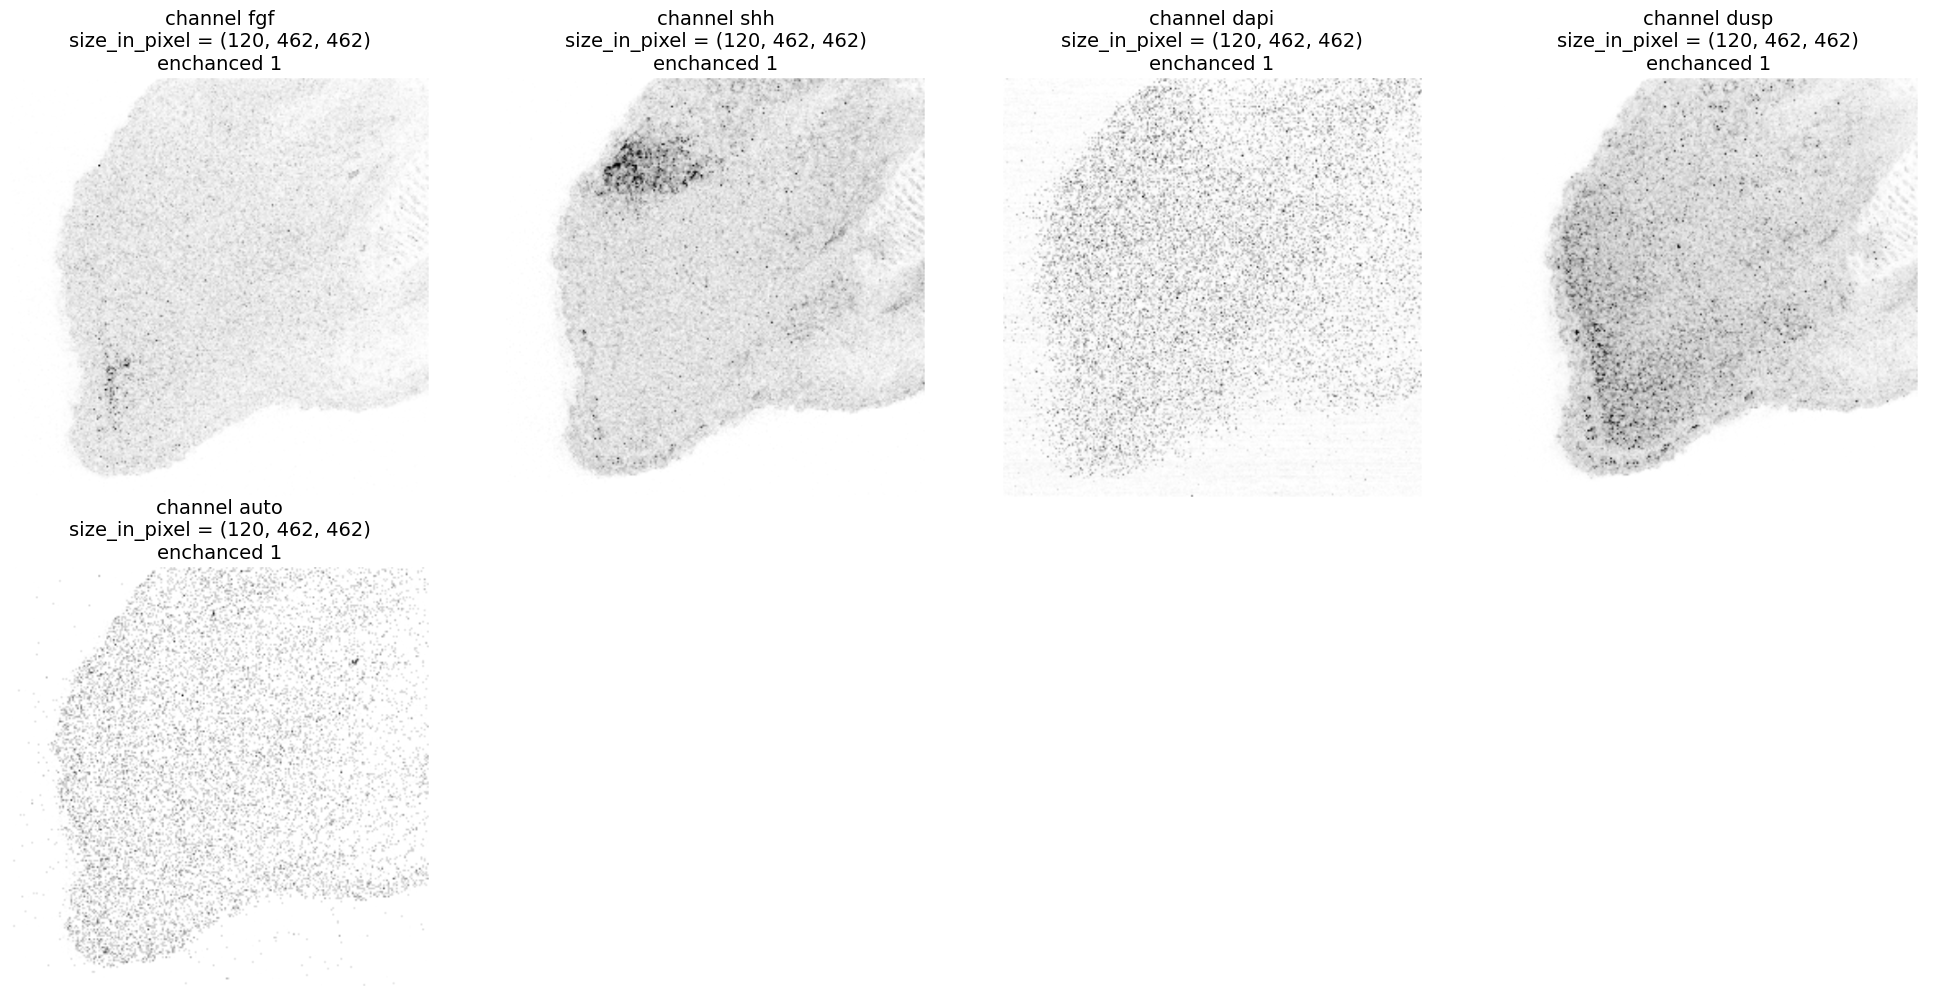

In [19]:
plot.preview(img, 0.5, 1, False, 'none')

# (Rotate) and Crop tissue

In [20]:
img = roi.rotate(img, 0, 0, -45)

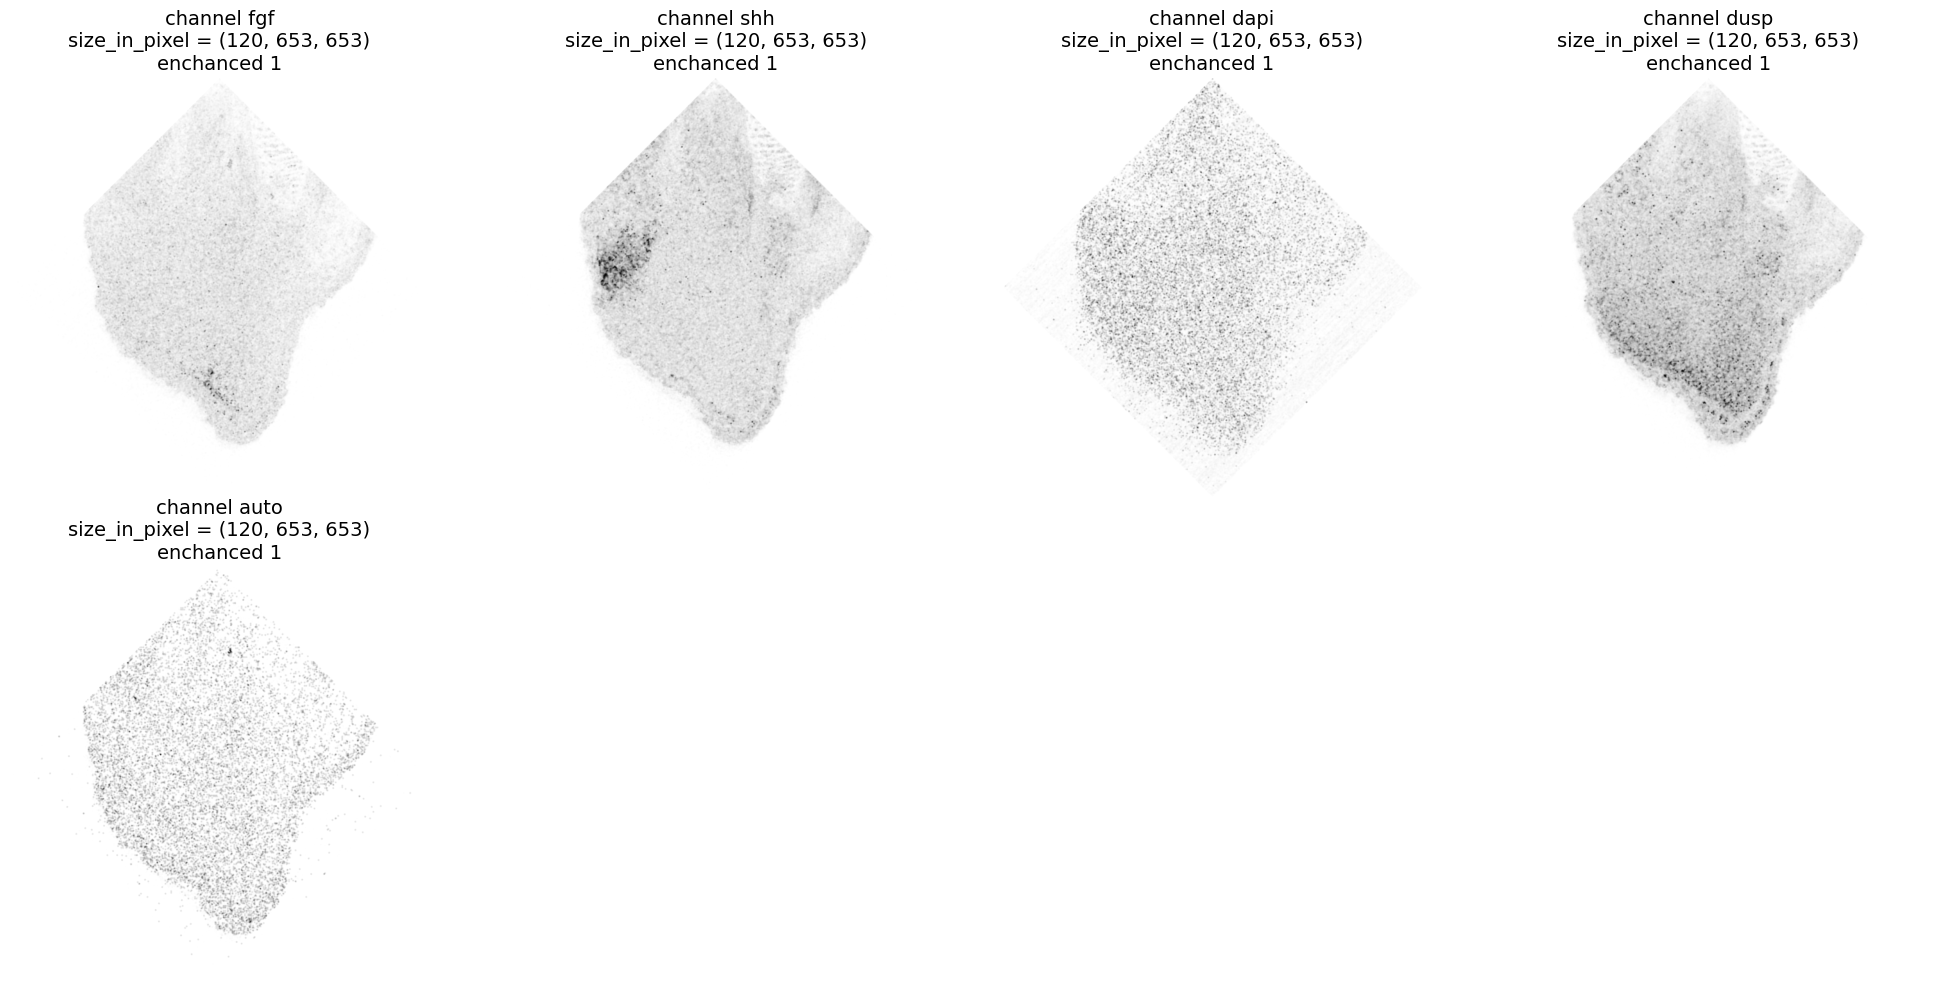

In [21]:
plot.preview(img, 0.5, 1, False, 'none')

In [22]:
for key in img.keys():
    img[key] = img[key][:, int(330/downsample):, :]

# Tissue mask

## Tissue mask name

In [23]:
# make mask name
print('tissue mask name:')
mask_segmeter_path = 'tissue_mask_2_5cm.cl'#os.path.join( os.path.dirname( img_path ), os.path.splitext( os.path.basename( img_path ) )[0] + '_mask.cl')
print(mask_segmeter_path)

tissue mask name:
tissue_mask_2_5cm.cl


## Segment tissue

In [24]:
# python code to apply this object segmenter
segmenter = ObjectSegmenter(opencl_filename=mask_segmeter_path)
result = segmenter.predict(
    image = cle.scale(img['dusp'], None, 0.2, 0.2, 0.2, centered=False, auto_size=True, linear_interpolation=True).astype( np.uint16 )
)
segmentation_lpcm = cle.label_pixel_count_map(result)
#keep only the largest object 
img['tissue_mask'] = (np.where(segmentation_lpcm ==  np.max(segmentation_lpcm), 1, 0)).astype( np.uint16 )

In [25]:
@widgets.interact(z_position = (0, 0.9, 0.1))

def preview_images_z(z_position=0.5):
    z = int(z_position * img['tissue_mask'].shape[0])
    plt.imshow( img['tissue_mask'][ z, :, :], cmap='binary')

interactive(children=(FloatSlider(value=0.5, description='z_position', max=0.9), Output()), _dom_classes=('wid…

In [26]:
j = 0
for i in img['tissue_mask']:
    i[-1, :] = 1
    i[:, -1] = 1
    img['tissue_mask'][j, :, :] = ndimage.binary_fill_holes(i)
    j = j + 1

In [27]:
img['tissue_mask'] = mask.morph_change(img['tissue_mask'], 10, True)

In [28]:
img['tissue_mask'] = cle.scale(img['tissue_mask'], None, 5, 5, 5, centered=False, auto_size=True, linear_interpolation=True)
img['tissue_mask'] = np.array(img['tissue_mask'])
k,j,i = img['fgf'].shape
img['tissue_mask'] = img['tissue_mask'][0:k, 0:j, 0:i]
img['tissue_mask'] = (img['tissue_mask'] > 0).astype( np.uint16 )

In [29]:
img['tissue_mask'] = mask.morph_change(img['tissue_mask'], 5, True)

# Epidermis mask

In [30]:
img['epidermis_mask'] = mask.epiderm(img['tissue_mask'], int(45/downsample), extend_along_z=True)

# Crop only tissue

In [31]:
img = mask.crop(img, img['epidermis_mask'])

dictionary, with 3d data


# Substruct artifacts

In [32]:
print('auto mask name:')

#from inputs import shh_segmenter as segmeter_path

segmeter_path = 'artifacts_2_5cm.cl'#os.path.join( os.path.dirname( img_path ), os.path.splitext( os.path.basename( img_path ) )[0] + '_shh_mask.cl')

print(segmeter_path)

auto mask name:
artifacts_2_5cm.cl


In [33]:
ch_name = 'auto'

In [34]:
# python code to apply this object segmenter
segmenter = ObjectSegmenter(opencl_filename=segmeter_path)
result = segmenter.predict( image = img[ch_name] )
segmentation_lpcm = cle.label_pixel_count_map(result)

In [35]:
img[ch_name+'_mask'] = (np.where(segmentation_lpcm > 0.1*np.max(segmentation_lpcm), 1, 0)).astype( np.uint16 )

In [36]:
img[ch_name+'_clip'] = img[ch_name] * img[ch_name+'_mask']

# Substruct background

In [37]:
import copy
img['tissue_mask_with_epi'] = copy.deepcopy(img['tissue_mask'])
img['tissue_mask']          = img['tissue_mask'] * mask.invert(img['epidermis_mask']) * mask.invert(img['auto_mask'])

In [38]:
for key in img.keys():
    if key.find('mask') < 0:
        img[key] = mask.subtract_bg_clip(img[key], img['tissue_mask'], img['tissue_mask_with_epi'])

masks for clipping and bg substr are diff
Mean background value = 182.19824797545155
masks for clipping and bg substr are diff
Mean background value = 293.4033395655529
masks for clipping and bg substr are diff
Mean background value = 160.70616869922682
masks for clipping and bg substr are diff
Mean background value = 191.69706361051522
masks for clipping and bg substr are diff
Mean background value = 228.20829608166133
masks for clipping and bg substr are diff
Mean background value = 0


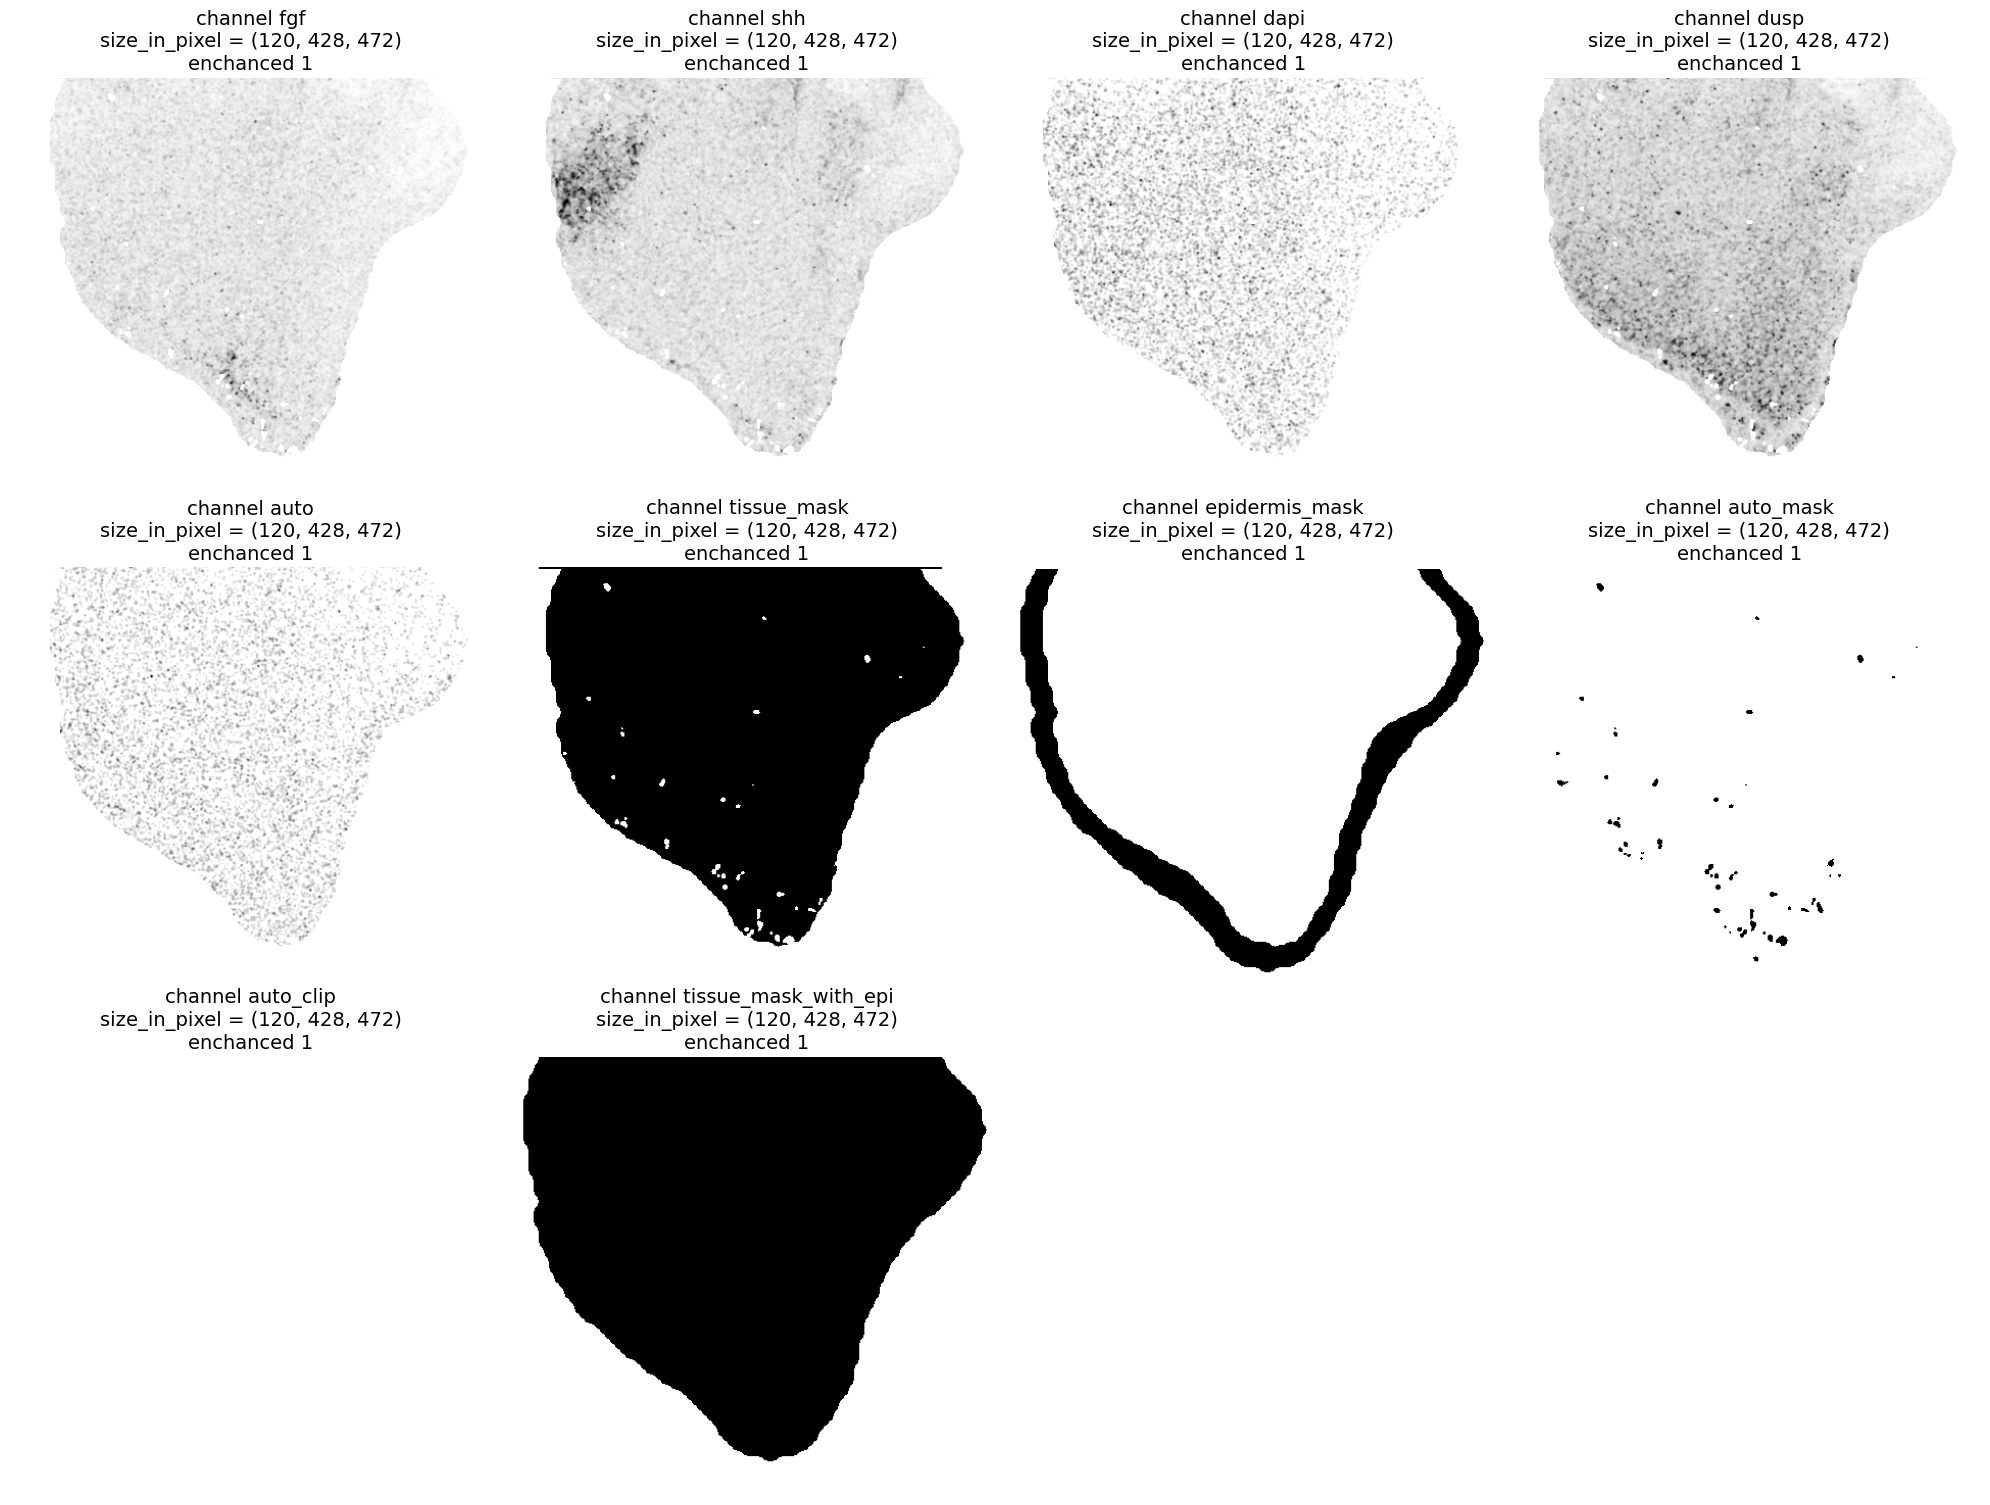

In [39]:
plot.preview(img, 0.5, 1, False, 'none')

# Segment Shh

In [40]:
ch_name = 'shh'

In [41]:
image_filtered = mask.gfilter( img[ch_name], sigma )
image_filtered = mask.minmaxnorm( image_filtered )

relative dynamic range, (max - min)/max = 0.9303791648169601


In [42]:
for pc in [40, 60, 70, 80]:
    img[ch_name + str(pc) + '_mask'] = (image_filtered > pc * 0.01).astype(np.uint16)
    img[ch_name + str(pc) + '_clip'] = img[ch_name] * img[ch_name + str(pc) + '_mask']

In [43]:
img[ch_name+'50_mask'] = (image_filtered > 0.5).astype(np.uint16)
img[ch_name+'50_clip'] = img[ch_name] * img[ch_name+'50_mask']

# Segment Fgf8

In [44]:
ch_name = 'fgf'

In [45]:
image_filtered = mask.gfilter( img[ch_name], sigma )
image_filtered = mask.minmaxnorm( image_filtered )

relative dynamic range, (max - min)/max = 0.9499331369735132


In [46]:
for pc in [40, 60, 70, 80]:
    img[ch_name + str(pc) + '_mask'] = (image_filtered > pc * 0.01).astype(np.uint16)
    img[ch_name + str(pc) + '_clip'] = img[ch_name] * img[ch_name + str(pc) + '_mask']

In [47]:
img[ch_name+'50_mask'] = (image_filtered > 0.5).astype(np.uint16)
img[ch_name+'50_clip'] = img[ch_name] * img[ch_name+'50_mask']

## Segment Dusp

In [48]:
ch_name = 'dusp'

In [49]:
image_filtered = mask.gfilter( img[ch_name], sigma )
image_filtered = mask.minmaxnorm( image_filtered )

relative dynamic range, (max - min)/max = 0.9168120452948053


In [50]:
for pc in [40, 60, 70, 80]:
    img[ch_name + str(pc) + '_mask'] = (image_filtered > pc * 0.01).astype(np.uint16)
    img[ch_name + str(pc) + '_clip'] = img[ch_name] * img[ch_name + str(pc) + '_mask']

In [51]:
img[ch_name+'50_mask'] = (image_filtered > 0.5).astype(np.uint16)
img[ch_name+'50_clip'] = img[ch_name] * img[ch_name+'50_mask']

# Save preprocessed image

In [52]:
img_arr = np.array( [img[key] for key in img.keys()] )
img_arr_keys = np.array( [key for key in img.keys()] )

In [53]:
folder_to_save = r'example_pretreated_images/'

In [54]:
file_to_save = f'hcr21_{sample}'
file_to_save

'hcr21_2_5cm_7dpa_noif'

In [55]:
path_to_save = os.path.join(folder_to_save, file_to_save)

In [56]:
np.save( path_to_save, img_arr)

In [57]:
np.save( path_to_save.split('.')[0] + '_keys.npy', img_arr_keys )

In [58]:
np.save( path_to_save.split('.')[0] + '_pixel.npy', pixel_size )